Using device: cuda
Model param count: 4,480,474 (must be <= 5,000,000)


100%|██████████| 170M/170M [00:13<00:00, 12.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch[001/500] LR=0.02000 TrainLoss=2.2965, Acc=11.11% || ValLoss=2.2339, Acc=15.05%
Epoch[002/500] LR=0.04000 TrainLoss=2.2239, Acc=15.64% || ValLoss=2.1648, Acc=19.66%
Epoch[003/500] LR=0.06000 TrainLoss=2.1596, Acc=18.19% || ValLoss=2.0365, Acc=26.42%
Epoch[004/500] LR=0.08000 TrainLoss=2.0857, Acc=22.95% || ValLoss=1.7603, Acc=39.89%
Epoch[005/500] LR=0.10000 TrainLoss=2.0295, Acc=28.73% || ValLoss=1.8752, Acc=38.27%
Epoch[006/500] LR=0.10000 TrainLoss=1.9729, Acc=31.09% || ValLoss=1.4996, Acc=55.13%
Epoch[007/500] LR=0.10000 TrainLoss=1.8913, Acc=30.86% || ValLoss=1.6219, Acc=50.91%
Epoch[008/500] LR=0.10000 TrainLoss=1.8576, Acc=36.27% || ValLoss=1.4657, Acc=57.61%
Epoch[009/500] LR=0.09999 TrainLoss=1.8529, Acc=37.12% || ValLoss=1.3721, Acc=62.28%
Epoch[010/500] LR=0.09998 TrainLoss=1.8243, Acc=37.64% || ValLoss=1.3564, Acc=62.78%
Epoch[011/500] LR=0.09998 TrainLoss=1.8148, Acc=39.13% || Val

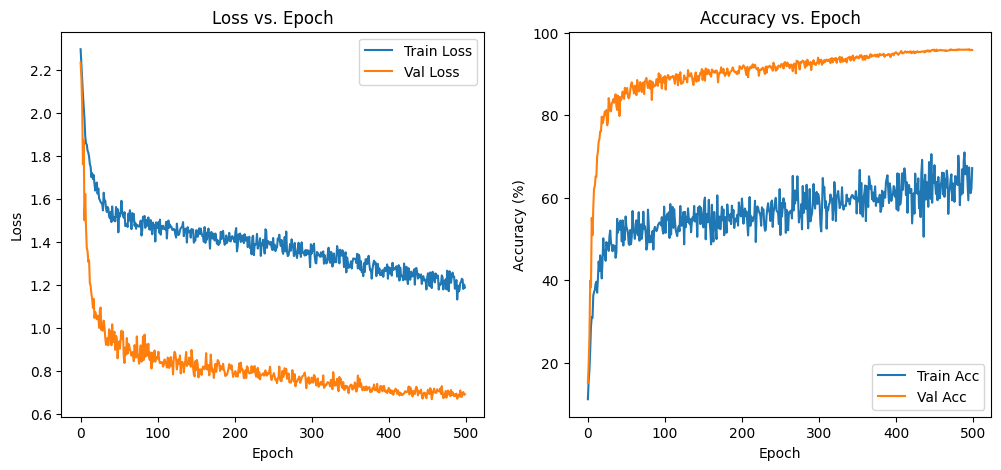

<ipython-input-1-db655f5ec6f1>:499: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_model.load_state_dict(torch.load(final_path))



Submission CSV 'submission.csv' created with 10000 rows.


In [ ]:
##############################################
#  CELL 1: Imports & Global Setup
##############################################
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import random
import matplotlib.pyplot as plt
import pickle
import csv
import copy
import os

# For reproducibility
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


##############################################
#  CELL 2: A Slightly Larger WRN-28-x
#   still <5M parameters (widen_factor=3.5)
##############################################
# We'll adapt the standard WRN code to allow float widen_factor.
# Then we'll round the channel counts carefully.
# Usually, WRN-28-3.5 is ~4.7M params,
# giving you more capacity than WRN-28-3 (3.4M) but <5M.

class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride=1, dropout_rate=0.0):
        super(BasicBlock, self).__init__()
        self.bn1   = nn.BatchNorm2d(in_planes)
        self.relu  = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(
            in_planes, out_planes, kernel_size=3,
            stride=stride, padding=1, bias=False
        )
        self.bn2   = nn.BatchNorm2d(out_planes)
        self.conv2 = nn.Conv2d(
            out_planes, out_planes, kernel_size=3,
            stride=1, padding=1, bias=False
        )
        self.dropout_rate = dropout_rate
        self.dropout = nn.Dropout(p=dropout_rate)

        # Shortcut
        self.equalInOut = (in_planes == out_planes)
        if not self.equalInOut:
            self.shortcut = nn.Conv2d(
                in_planes, out_planes,
                kernel_size=1, stride=stride, bias=False
            )

    def forward(self, x):
        out = self.relu(self.bn1(x))
        if not self.equalInOut:
            x = self.shortcut(out)
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.relu(out)
        if self.dropout_rate > 0:
            out = self.dropout(out)
        out = self.conv2(out)
        return out + x


class NetworkBlock(nn.Module):
    def __init__(self, num_layers, in_planes, out_planes,
                 block, stride, dropout_rate=0.0):
        super(NetworkBlock, self).__init__()
        layers = []
        for i in range(num_layers):
            s = stride if i == 0 else 1
            inc = in_planes if i == 0 else out_planes
            layers.append(block(inc, out_planes, s, dropout_rate))
        self.layer = nn.Sequential(*layers)

    def forward(self, x):
        return self.layer(x)


class WideResNet(nn.Module):
    """
    A wide ResNet that allows non-integer widen_factor:
      e.g. WRN-28-3.5 => ~4.7M params if dropout=0.4.
    """
    def __init__(self, depth, widen_factor, dropout_rate, num_classes):
        super(WideResNet, self).__init__()
        self.in_planes = 16
        assert ((depth - 4) % 6 == 0), "Depth must be 6n+4"
        n = (depth - 4) // 6
        k = float(widen_factor)

        # We'll round channel sizes to nearest integer:
        nStages = [
            16,
            int(round(16*k)),
            int(round(32*k)),
            int(round(64*k))
        ]

        self.conv1 = nn.Conv2d(
            3, nStages[0], kernel_size=3, stride=1,
            padding=1, bias=False
        )
        self.block1 = NetworkBlock(n, nStages[0], nStages[1],
                                   BasicBlock, stride=1,
                                   dropout_rate=dropout_rate)
        self.block2 = NetworkBlock(n, nStages[1], nStages[2],
                                   BasicBlock, stride=2,
                                   dropout_rate=dropout_rate)
        self.block3 = NetworkBlock(n, nStages[2], nStages[3],
                                   BasicBlock, stride=2,
                                   dropout_rate=dropout_rate)
        self.bn    = nn.BatchNorm2d(nStages[3])
        self.relu  = nn.ReLU(inplace=True)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc    = nn.Linear(nStages[3], num_classes)

        # He init
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)

    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn(out))
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        return self.fc(out)


def create_wrn28_x(num_classes=10, widen_factor=3.5, dropout_rate=0.4):
    return WideResNet(depth=28, widen_factor=widen_factor,
                      dropout_rate=dropout_rate,
                      num_classes=num_classes)


##############################################
#  CELL 3: Instantiate & Param Count
##############################################
model = create_wrn28_x(num_classes=10, widen_factor=3.5, dropout_rate=0.4).to(device)
n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model param count: {n_params:,} (must be <= 5,000,000)")


##############################################
#  CELL 4: Data & Domain-Focused Augmentations
##############################################
# We'll stack:
#  1) AutoAugment(CIFAR10)
#  2) ColorJitter => handle brightness/contrast mismatch
#  3) RandomGrayscale(0.1) => handle partial grayscale
#  4) RandomErasing(0.2)
#  5) Large batch
#  6) Potentially TTA later

MEAN = [0.4914, 0.4822, 0.4465]
STD  = [0.2023, 0.1994, 0.2010]

train_transform = transforms.Compose([
    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.2),
    transforms.Normalize(MEAN, STD),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

train_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True,
    transform=train_transform
)
test_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True,
    transform=test_transform
)

BATCH_SIZE = 512  # or 512 if you have enough GPU memory
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE,
    shuffle=True, num_workers=2, pin_memory=True
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE,
    shuffle=False, num_workers=2, pin_memory=True
)


##############################################
#  CELL 5: Mixup + CutMix + Label Smoothing
##############################################
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing
        self.confidence = 1.0 - smoothing

    def forward(self, x, target):
        log_probs = F.log_softmax(x, dim=-1)
        with torch.no_grad():
            true_dist = torch.zeros_like(log_probs)
            true_dist.fill_(self.smoothing / (x.size(1)-1))
            true_dist.scatter_(1, target.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * log_probs, dim=1))


def rand_bbox(size, lam):
    W = size[3]
    H = size[2]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)
    cx = np.random.randint(W)
    cy = np.random.randint(H)
    bbx1 = np.clip(cx - cut_w//2, 0, W)
    bby1 = np.clip(cy - cut_h//2, 0, H)
    bbx2 = np.clip(cx + cut_w//2, 0, W)
    bby2 = np.clip(cy + cut_h//2, 0, H)
    return bbx1, bby1, bbx2, bby2


def dual_mix_data(x, y, alpha_mix=0.8, alpha_cut=0.8, p_cutmix=0.5):
    """
    Randomly choose Mixup or CutMix each batch.
    Let's use alpha=0.8 for both as an example.
    p_cutmix=0.5 => 50% chance do CutMix, else Mixup
    """
    if alpha_mix <= 0 and alpha_cut <= 0:
        return x, y, y, 1.0, "none"

    do_cutmix = (np.random.rand() < p_cutmix)

    if do_cutmix and alpha_cut>0:
        lam = np.random.beta(alpha_cut, alpha_cut)
        bs = x.size(0)
        index = torch.randperm(bs).to(x.device)
        bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
        x[:, :, bby1:bby2, bbx1:bbx2] = x[index, :, bby1:bby2, bbx1:bbx2]

        lam = 1 - ((bbx2-bbx1)*(bby2-bby1)/(x.size(-1)*x.size(-2)))
        y_a, y_b = y, y[index]
        return x, y_a, y_b, lam, "cutmix"
    else:
        lam = np.random.beta(alpha_mix, alpha_mix)
        bs = x.size(0)
        index = torch.randperm(bs).to(x.device)
        mixed_x = lam*x + (1-lam)*x[index,:]
        y_a, y_b = y, y[index]
        return mixed_x, y_a, y_b, lam, "mixup"


def dualmix_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1-lam)*criterion(pred, y_b)


##############################################
#  CELL 6: Warmup + Cosine LR, SWA Utils
##############################################
def warmup_cosine_lr(optimizer, epoch, warmup_epochs, base_lr, final_lr, total_epochs):
    """
    Warmup for 'warmup_epochs', then Cosine decay from base_lr to final_lr.
    """
    if epoch < warmup_epochs:
        # linearly scale from 0 -> base_lr
        lr = base_lr * float(epoch+1)/warmup_epochs
    else:
        # Cosine
        progress = float(epoch - warmup_epochs)/float(total_epochs - warmup_epochs)
        lr = final_lr + 0.5*(base_lr - final_lr)*(1 + np.cos(np.pi*progress))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr


def bn_update(loader, model):
    """Update BN stats with no gradients."""
    model.train()
    with torch.no_grad():
        for imgs, _ in loader:
            imgs = imgs.to(device)
            _ = model(imgs)


def update_swa_params(swa_model, model, alpha):
    for swa_p, p in zip(swa_model.parameters(), model.parameters()):
        swa_p.data.mul_(alpha).add_(p.data, alpha=1-alpha)


##############################################
#  CELL 7: Training / Evaluate
##############################################
def train_one_epoch(
    model, loader, optimizer, criterion,
    alpha_mix=0.8, alpha_cut=0.8, p_cutmix=0.5
):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)

        inputs, y_a, y_b, lam, mode = dual_mix_data(
            imgs, labels,
            alpha_mix=alpha_mix, alpha_cut=alpha_cut,
            p_cutmix=p_cutmix
        )

        outputs = model(inputs)
        loss = dualmix_criterion(criterion, outputs, y_a, y_b, lam)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()*imgs.size(0)
        _, pred = outputs.max(1)
        correct += pred.eq(y_a).sum().item()  # approximate
        total += labels.size(0)

    return running_loss/total, 100.*correct/total


def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            out = model(imgs)
            loss = criterion(out, labels)
            running_loss += loss.item()*imgs.size(0)
            _, pred = out.max(1)
            correct += pred.eq(labels).sum().item()
            total += labels.size(0)
    return running_loss/total, 100.*correct/total


##############################################
#  CELL 8: Main Training Loop
##############################################
criterion = LabelSmoothingCrossEntropy(smoothing=0.1)

optimizer = optim.SGD(
    model.parameters(), lr=0.0,
    momentum=0.9, weight_decay=5e-4
)

EPOCHS = 1000
WARMUP_EPOCHS = 5
BASE_LR   = 0.1
FINAL_LR  = 1e-4
SWA_START = 350

swa_model = copy.deepcopy(model)
swa_count = 0
best_acc_normal = 0.0

train_loss_hist, train_acc_hist = [], []
val_loss_hist,   val_acc_hist   = [], []

for epoch in range(EPOCHS):
    # Warmup + Cosine LR
    current_lr = warmup_cosine_lr(
        optimizer, epoch,
        warmup_epochs=WARMUP_EPOCHS,
        base_lr=BASE_LR,
        final_lr=FINAL_LR,
        total_epochs=EPOCHS
    )

    # Train
    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer, criterion,
        alpha_mix=0.8, alpha_cut=0.8, p_cutmix=0.5
    )

    # Evaluate
    val_loss, val_acc = evaluate(model, test_loader, criterion)

    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)
    val_loss_hist.append(val_loss)
    val_acc_hist.append(val_acc)

    # Track best normal model
    if val_acc > best_acc_normal:
        best_acc_normal = val_acc
        torch.save(model.state_dict(), "best_wrn28_3p5_normal.pth")

    # SWA update after SWA_START
    if epoch >= SWA_START:
        swa_count += 1
        alpha = (swa_count - 1)/swa_count
        update_swa_params(swa_model, model, alpha=alpha)

    print(f"Epoch[{epoch+1:03d}/{EPOCHS}] LR={current_lr:.5f} "
          f"TrainLoss={train_loss:.4f}, Acc={train_acc:.2f}% || "
          f"ValLoss={val_loss:.4f}, Acc={val_acc:.2f}%")

print("\nTraining done!")
print(f"Best normal model acc: {best_acc_normal:.2f}%")


# Finalize SWA
if swa_count > 0:
    swa_model.to(device)
    bn_update(train_loader, swa_model)
    val_loss_swa, val_acc_swa = evaluate(swa_model, test_loader, criterion)
    torch.save(swa_model.state_dict(), "best_wrn28_3p5_swa.pth")
    print(f"SWA model test accuracy: {val_acc_swa:.2f}%")
else:
    val_loss_swa, val_acc_swa = val_loss, val_acc_swa
    torch.save(model.state_dict(), "best_wrn28_3p5_swa.pth")


##############################################
#  CELL 9: Plot Curves
##############################################
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(val_loss_hist,   label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_acc_hist, label="Train Acc")
plt.plot(val_acc_hist,   label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs. Epoch")
plt.legend()

plt.show()


##############################################
#  CELL 10: TTA Inference + CSV
##############################################
# We'll do 10 random flips/crops per test image. That can help a bit more
# than the usual 5. If the custom test set is drastically different, you can
# add slight color jitter or random grayscale in TTA as well—but be cautious
# not to over-distort.

tta_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

def tta_inference(model, img_np, n_augs=10):
    """Apply TTA to a single image; average predictions."""
    model.eval()
    if img_np.shape == (3*32*32,):
        img_np = img_np.reshape(3,32,32).transpose(1,2,0)
    base_tensor = torch.from_numpy(img_np).float()/255.0
    base_tensor = base_tensor.permute(2,0,1)  # => (3,32,32)

    preds_sum = 0
    with torch.no_grad():
        for _ in range(n_augs):
            pil_img = transforms.ToPILImage()(base_tensor)
            aug_tensor = tta_transform(pil_img).unsqueeze(0).to(device)
            out = model(aug_tensor)
            preds_sum += F.softmax(out, dim=1)
    preds_mean = preds_sum / n_augs
    _, pred_label = preds_mean.max(1)
    return pred_label.item()

# Decide which final model to use: SWA or normal
model_path_swa    = "best_wrn28_3p5_swa.pth"
model_path_normal = "best_wrn28_3p5_normal.pth"
final_path = model_path_swa if os.path.exists(model_path_swa) else model_path_normal

final_model = create_wrn28_x(num_classes=10, widen_factor=3.5, dropout_rate=0.4).to(device)
final_model.load_state_dict(torch.load(final_path))
final_model.eval()

# Generate CSV
custom_test_path = "/content/cifar_test_nolabel.pkl"  # adjust if needed
try:
    with open(custom_test_path, "rb") as f:
        custom_test_data = pickle.load(f)

    unlabeled_imgs = custom_test_data[b'data']
    unlabeled_ids  = custom_test_data[b'ids']

    predictions = []
    for i in range(len(unlabeled_imgs)):
        label_pred = tta_inference(final_model, unlabeled_imgs[i], n_augs=10)
        predictions.append((unlabeled_ids[i], label_pred))

    csv_filename = "submission.csv"
    with open(csv_filename, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["ID","Labels"])
        for (img_id, label) in predictions:
            writer.writerow([img_id, label])

    print(f"\nSubmission CSV '{csv_filename}' created with {len(predictions)} rows.")

except FileNotFoundError:
    print(f"File '{custom_test_path}' not found. Please upload it first.")
